In [1]:
from sklearn.ensemble import RandomForestClassifier

In [2]:
import pandas as pd
import sklearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score

In [59]:
new_train = pd.read_csv("../new_train.csv")
new_test = pd.read_csv("../new_test.csv")

In [60]:
new_train.drop(new_train.filter(regex="Unname"),axis=1, inplace=True)
new_test.drop(new_test.filter(regex="Unname"),axis=1, inplace=True)

In [61]:
X = new_train.drop(columns=['bidder_id', 'payment_account', 'address', 'outcome','merchandise'])
y = new_train['outcome']

In [62]:
len(X.columns)

52

In [63]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.29839867, -0.34020786, -0.13219046, ..., -0.36967066,
        -0.37052414,  2.16467791],
       [-0.41452291, -0.40452956, -0.13438925, ..., -0.36967066,
        -0.37052414,  0.73029739],
       [-0.39403039, -0.40452956, -0.13428454, ..., -0.36967066,
        -0.37052414,  0.73029739],
       ...,
       [-0.41452291, -0.40452956, -0.13449395, ..., -0.36967066,
        -0.37052414, -0.70408314],
       [-0.41452291, -0.4098897 , -0.13459866, ..., -0.36967066,
        -0.37052414, -0.70408314],
       [-0.41452291, -0.4098897 , -0.13449395, ..., -0.36967066,
        -0.37052414, -0.70408314]])

In [64]:
model = RandomForestClassifier(n_estimators=500, max_features=10,
                                   max_depth=8, random_state=20,
                                   criterion='entropy',)


In [65]:
sm = SMOTE()
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.7, random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
acc_score = model.score(X_test, y_test)
auc_roc_score = roc_auc_score(y_test,y_pred)

In [66]:
acc_score

0.9617021276595744

In [67]:
auc_roc_score

0.648538961038961

In [112]:
importances =model.feature_importances_

<BarContainer object of 52 artists>

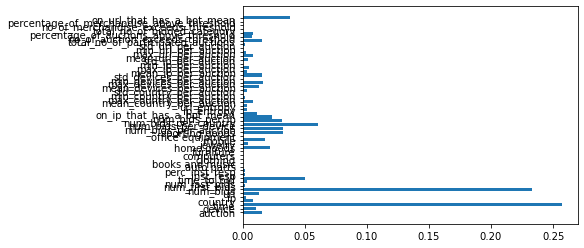

In [113]:
forest_importances = pd.Series(importances, index=X.columns)

plt.barh(X.columns,importances)

In [21]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt',5,10,25]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,8,10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [22]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)

    
    accuracy = accuracy_score(test_labels, predictions)
    auc_roc_score = roc_auc_score(y_test,predictions)
    
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('AUC ROC = {:0.2f}%.'.format(auc_roc_score))
    
    return accuracy, auc_roc_score

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)



Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt', 5, 10,
                                                         25],
                                        'min_samples_leaf': [1, 2, 4, 8, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [23]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 8,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

In [25]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Accuracy = 0.95%.
AUC ROC = 0.54%.
Model Performance
Accuracy = 0.95%.
AUC ROC = 0.54%.


In [130]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [20,30, 40, 50],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1,2,3, 4, 5],
    'min_samples_split': [3, 5, 8,10],
    'n_estimators': [300, 400, 500, 1000]
}

rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [131]:
grid_search.fit(X_train_oversampled,y_train_oversampled)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [20, 30, 40, 50],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [3, 5, 8, 10],
                         'n_estimators': [300, 400, 500, 1000]},
             verbose=2)

In [132]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 300}

In [133]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)


Model Performance
Accuracy = 0.94%.
AUC ROC = 0.73%.
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   1.1s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   0.9s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   0.7s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=800; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=   0.6s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   0.8s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400; to

[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   1.1s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=1200; total time=   1.1s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=800; total time=   0.7s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=800; total time=   0.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   1.1s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   0.4s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=90, 

[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   1.2s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=1200; total time=   1.1s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   0.7s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=800; total time=   0.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   1.2s
[CV] END bootstrap=True, max_depth=70, max_features=10, min_samples_leaf=8, min_samples_split=5, n_estimators=400; total time=   0.4s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=None,

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=40, max_features=25, min_samples_leaf=8, min_samples_split=10, n_estimators=1000; total time=   1.6s
[CV] END bootstrap=True, max_depth=60, max_features=25, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=   2.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   0.7s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   0.7s
[CV] END bootstrap=False, max_depth=None, max_features=5, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   1.9s
[CV] END bootstrap=True, max_depth=20, max_fe

In [124]:
X_scaled


array([[-0.29839867, -0.34020786, -0.13219046, ..., -0.36967066,
        -0.37052414,  2.16467791],
       [-0.41452291, -0.40452956, -0.13438925, ..., -0.36967066,
        -0.37052414,  0.73029739],
       [-0.39403039, -0.40452956, -0.13428454, ..., -0.36967066,
        -0.37052414,  0.73029739],
       ...,
       [-0.41452291, -0.40452956, -0.13449395, ..., -0.36967066,
        -0.37052414, -0.70408314],
       [-0.41452291, -0.4098897 , -0.13459866, ..., -0.36967066,
        -0.37052414, -0.70408314],
       [-0.41452291, -0.4098897 , -0.13449395, ..., -0.36967066,
        -0.37052414, -0.70408314]])

In [125]:
X_train_oversampled

array([[-0.33255286, -0.32412744, -0.13271398, ..., -0.36967066,
        -0.37052414, -0.29426013],
       [-0.39403039, -0.39380927, -0.13428454, ..., -0.36967066,
        -0.37052414,  0.73029739],
       [-0.38719956, -0.38844913, -0.13376102, ..., -0.36967066,
        -0.37052414,  2.16467791],
       ...,
       [-0.17545269, -0.29051003, -0.11824569, ..., -0.36967066,
        -0.37052414, -0.69035762],
       [-0.40181851, -0.39962738, -0.13253676, ..., -0.36967066,
        -0.37052414, -0.70223695],
       [-0.24034382, -0.40079201, -0.08175845, ..., -0.36967066,
        -0.37052414, -0.08121986]])